# Import and prepare data
Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import datetime as dt
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold

%matplotlib inline

C:\Users\jingx\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Input dataset

In [2]:
pkf = open('dataset/Power.pkl','rb')
power,totalPower = pickle.load(pkf)
power['Heater'] = totalPower['HPE']
power['No heater'] = power['Power'] - power['Heater']
pkf.close()

In [3]:
pkf = open('dataset/nature.pkl','rb')
nature = pickle.load(pkf)
pkf.close()

In [4]:
powerhourly = power.groupby(pd.TimeGrouper(freq='1H')).mean()
alldata = nature.join(powerhourly, how='inner')

Drop null values

In [5]:
alldata = alldata.dropna()

In [6]:
alldata.isnull().sum()

temperature    0
visibility     0
press          0
weather        0
Power          0
Heater         0
No heater      0
dtype: int64

Classify weathers (1-38)

In [7]:
weather = alldata.weather.unique()
a = np.arange(1,39)
for i in range(len(weather)):
    alldata['weather'].iloc[np.where(np.array(alldata.weather)==weather[i])] = a[i]

dates = np.array([x.date() for x in alldata.index])
hours = np.array([x.hour for x in alldata.index])
weekdays = np.array([x.weekday() for x in alldata.index])
months = np.array([x.month for x in alldata.index])
alldata['Hour'] = hours
alldata['Day'] = dates
alldata['Weekday'] = weekdays
alldata['Month'] = months
alldataOneYear = alldata.iloc[:np.where(alldata.index.date==dt.date(2013, 4, 1))[0][0]]
# alldataOneYear

C:\Users\jingx\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Describe dataset
Plot consumption for one year to see the tendency

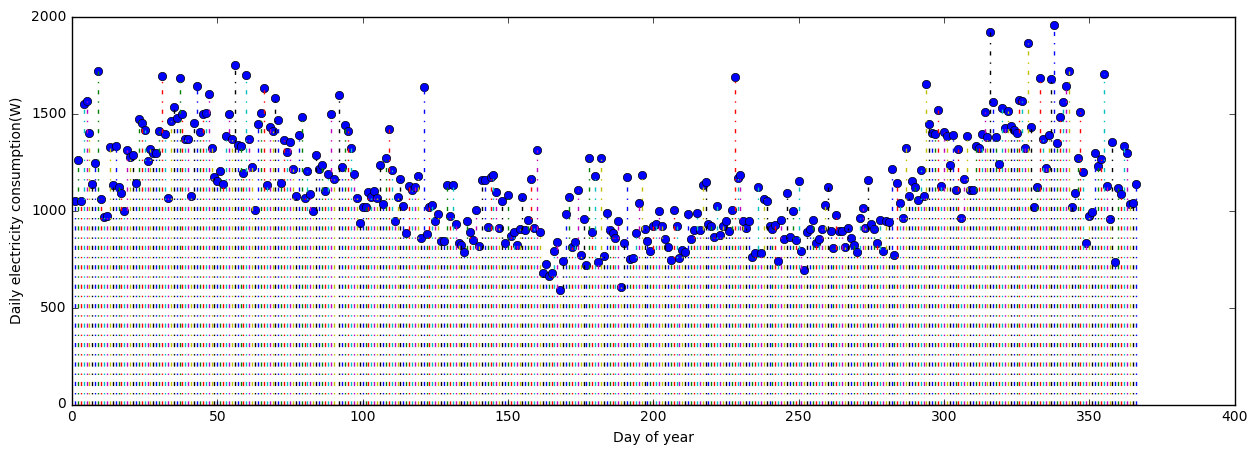

In [8]:
fig = plt.figure(figsize=(15,5))
alldataDaily = alldataOneYear['Power'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(alldataDaily.index, alldataDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Daily electricity consumption(W)')
plt.show()

Plot the temperature for one year to see its tendency

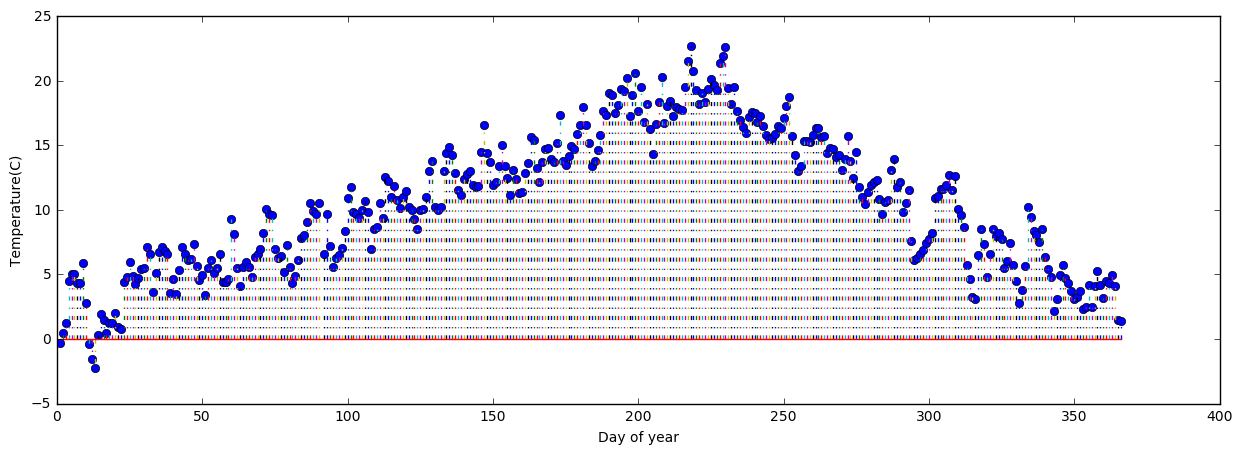

In [9]:
fig = plt.figure(figsize=(15,5))
alldataDaily = alldataOneYear['temperature'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(alldataDaily.index, alldataDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Temperature(C)')
plt.show()

The first histogram shows the average hourly consumption on the entire dataset.
7 subplots with similar histograms showing the average hourly consumption for each day of the week.

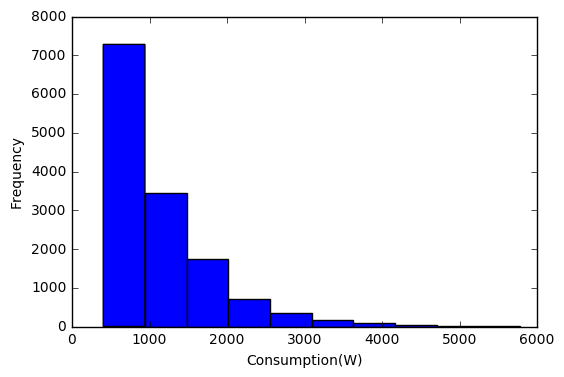

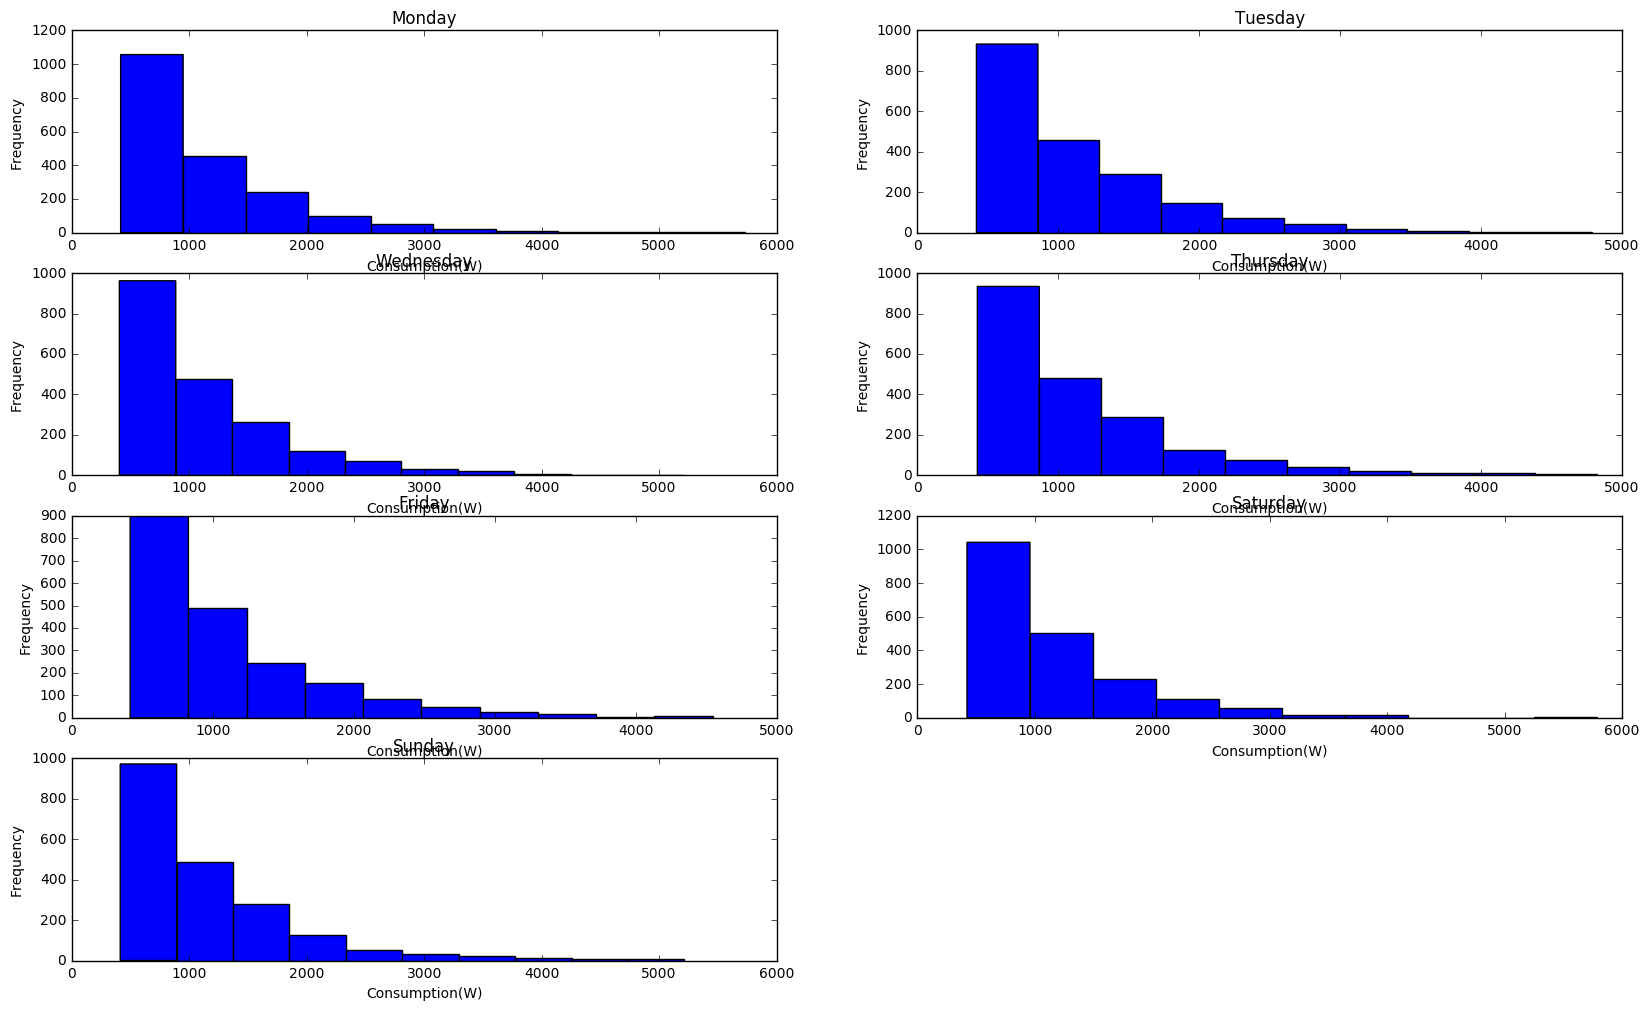

In [10]:
fig1 = plt.figure()
plt.hist(alldata.Power)
plt.xlabel('Consumption(W)')
plt.ylabel('Frequency')

Monday = alldata.ix[alldata.Weekday == 0]
Thusday = alldata.ix[alldata.Weekday == 1] 
Wensday = alldata.ix[alldata.Weekday == 2]
Thursday = alldata.ix[alldata.Weekday == 3]
Friday = alldata.ix[alldata.Weekday == 4]
Saturday = alldata.ix[alldata.Weekday == 5]
Sunday = alldata.ix[alldata.Weekday == 6]

All = [Monday, Thusday, Wensday, Thursday, Friday, Saturday, Sunday]

fig = plt.figure(figsize=(20,12))
Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    All[i].index = np.arange(len(All[i]))
    plt.subplot(4,2,i+1)
    plt.hist(All[i].Power)
    plt.title(Days[i])
    plt.xlabel('Consumption(W)')
    plt.ylabel('Frequency')
    plt.show

The first plot shows box plot of the average hourly electricity consumption for each hour of the day.
7 subplots showing the box plots for each of the seven days of the week.

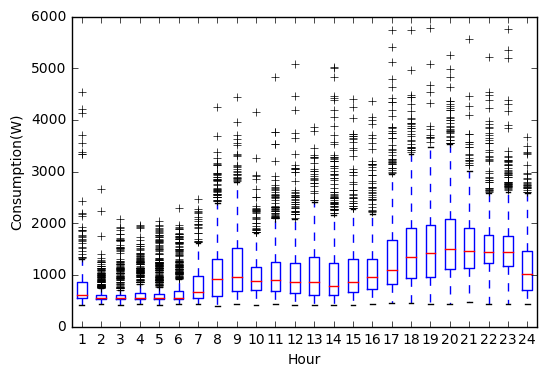

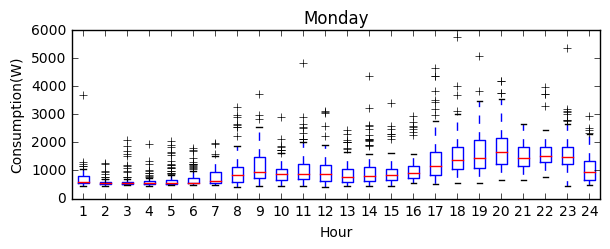

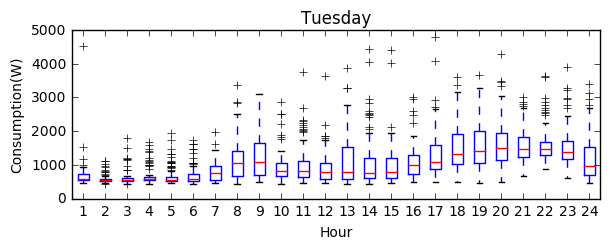

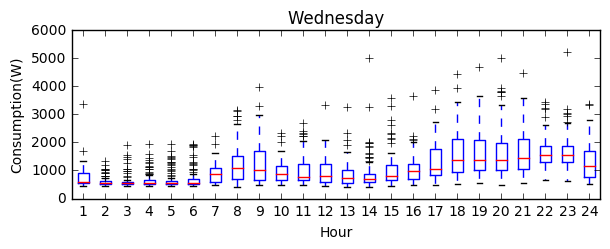

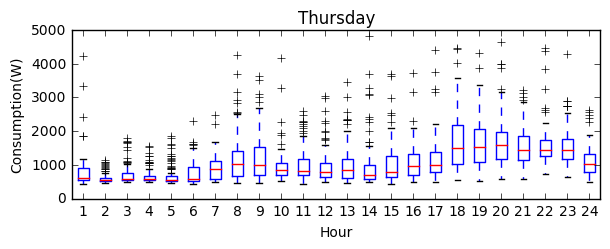

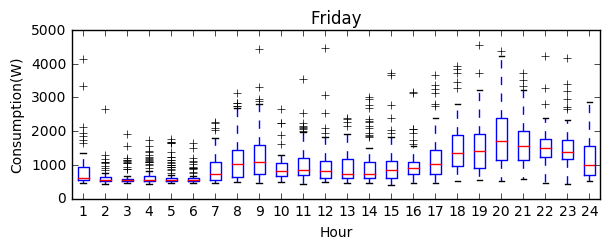

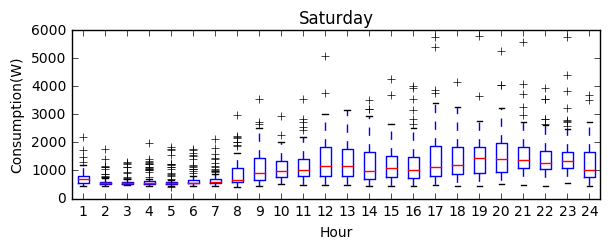

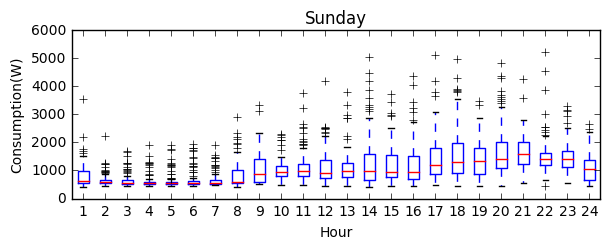

In [11]:
bp = []
for i in range(24):
    bp.append(np.array(alldata.groupby(['Hour','Day']).Power.mean().unstack(level=0)[i].dropna()))
plt.boxplot(bp)
plt.xlabel('Hour')
plt.ylabel('Consumption(W)')
plt.show()
    
bp = []
for i in range(7):
    fig = plt.figure(figsize=(15,10))
    plt.subplot(4,2,i+1)
    for j in range(24):
        bp.append(np.array(All[i].groupby(['Hour','Day']).Power.mean().unstack(level=0)[j].dropna()))
    plt.boxplot(bp)
    bp = []
    plt.title(Days[i])
    plt.xlabel('Hour')
    plt.ylabel('Consumption(W)')
    plt.show()

Heatmap of the daily load curves showing the hours of the day (24 in total), and the vertical axis showing the day of the year (365 total).

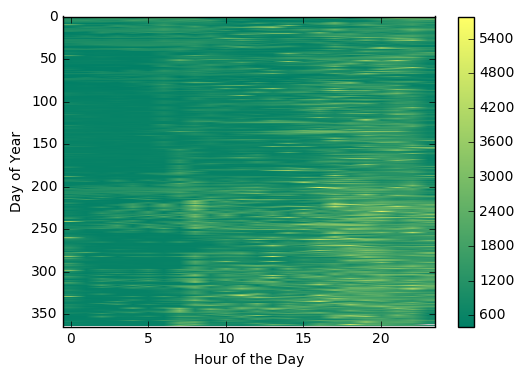

In [12]:
tmp = alldataOneYear[['Power','Hour','Day']].groupby(['Day','Hour'])['Power'].mean()
loadCurves = tmp.unstack(level=1)
# loadCurves.head()

normloadCurves = (loadCurves-loadCurves.min().min())/(loadCurves.max().max()-loadCurves.min().min())
fig = plt.figure(1)
plt.imshow(loadCurves, aspect='auto',cmap='summer')
plt.ylabel('Day of Year')
plt.xlabel('Hour of the Day')
plt.colorbar()
plt.show()


# Cluster Analysis
perform k-means on the dataset with  k = 2  and the dataset being 365 samples of 24-dimensional vectors.

(365, 24)


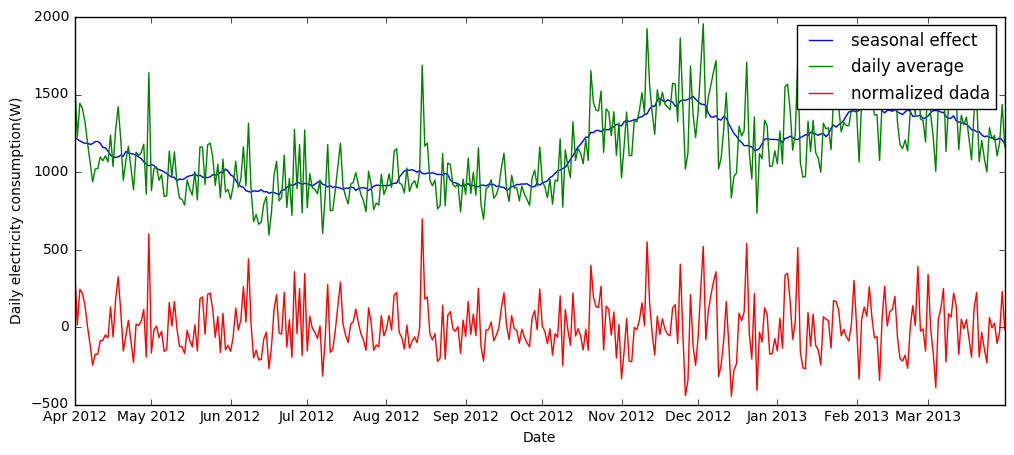

In [13]:
from sklearn.cluster import KMeans

loadCurves = loadCurves.replace(np.inf,np.nan).fillna(0)
Cx = loadCurves.as_matrix().astype(np.float32)
print(Cx.shape)

lp = 10
seasonal = []
for i in range(int(len(Cx))):
    seasonal.append(np.mean(Cx[np.max([i-lp,0]):i+lp,:]))
    
fig = plt.figure(1,figsize=(12,5))
plt.plot(loadCurves.index, seasonal, label='seasonal effect')
plt.plot(loadCurves.index, np.mean(Cx,axis=1), label='daily average')

normX = (Cx.T - seasonal).T
plt.plot(loadCurves.index, np.mean(normX,axis=1), label='normalized dada')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily electricity consumption(W)')

clusters = KMeans(n_clusters=2).fit(normX)

134
231


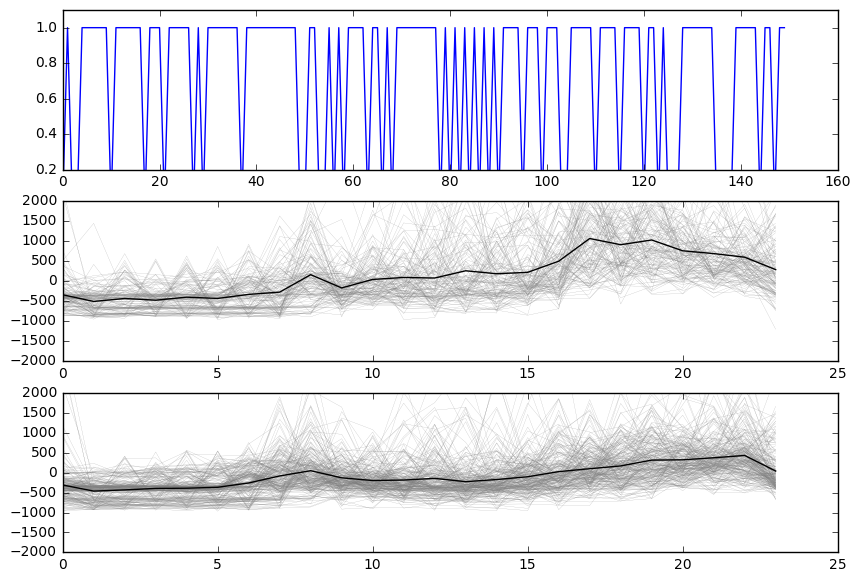

In [14]:
num_clust = 2

fig = plt.figure(1,figsize=(10,7))
cluster_assignments = clusters.predict(normX)
plt.subplot(num_clust+1,1,1)
plt.plot(cluster_assignments[:150])
plt.ylim([0.2,1.1])
for cluster_id in range(len(clusters.cluster_centers_)):
    plt.subplot(num_clust+1,1,cluster_id+2)
    cluster_members = normX[cluster_assignments==cluster_id,:]
    print(len(cluster_members))
    for i in range(len(cluster_members)):
        plt.plot(cluster_members[i,:], color='grey', lw='0.1')
    plt.plot(clusters.cluster_centers_[cluster_id,:], color='k', lw='1')
    plt.ylim([-2000,2000])

# Regression Tree
plot the temperature and consumption vs day in a same image

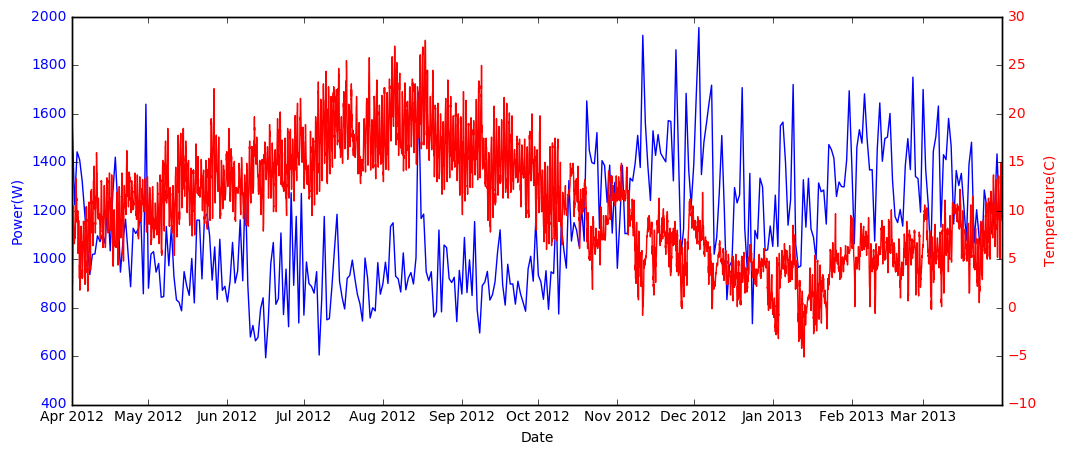

In [15]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(loadCurves.index, np.mean(Cx,axis=1),'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power(W)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(alldataOneYear.index,alldataOneYear['temperature'],'r')
ax2.set_ylabel('Temperature(C)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()


## Training
X is the feature dataframe and Y is the response dataframe. We use X and Y to do the desicion tree regression.

In [16]:
X = alldataOneYear[['temperature','press','visibility','weather','Hour','Weekday']]
Y = alldataOneYear['Power']

In [17]:
from sklearn import linear_model
dtr = DecisionTreeRegressor(max_depth=5)
mld = dtr.fit(X,Y)
print(mld.score(X,Y))


0.339277028264


## Validation
Find the best maximum depth for regreesion tree model.

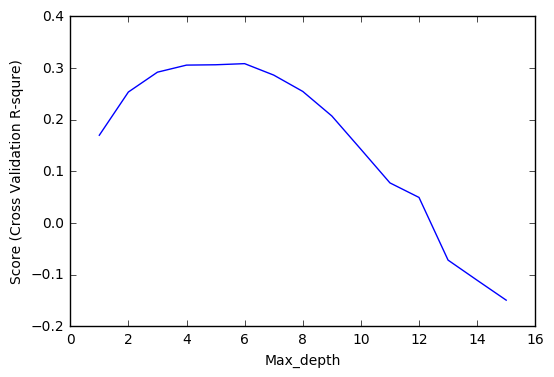

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
score = []
for depth in range(15):
    dtr1 = DecisionTreeRegressor(max_depth=depth+1)
    dtr1 = dtr1.fit(X,Y)
    score.append(cross_val_score(dtr1, X, Y, cv=KFold(n_splits=10, shuffle=True)).mean())
    
plt.plot(np.arange(1,16,1),score)
plt.xlabel('Max_depth')
plt.ylabel('Score (Cross Validation R-squre)')

Rearrange the feature and response dataframe. Put every 12 continous data into a list as one datapoint. 

In [19]:
powerOneYear = power.iloc[:np.where(power.index.date==dt.date(2013, 4, 1))[0][0]]
groupedPower = powerOneYear['Power'].groupby(pd.TimeGrouper(freq='1H')).aggregate(lambda x: x.tolist())
rX = X
groupedPower = groupedPower[rX.index]

rY = []
n = 0
for i in groupedPower:
    rY.append([])
    if(len(i) == 12):
        for j in i:
            rY[n].append(j)
    n+=1

clf1 = DecisionTreeRegressor(max_depth=5)
clf1 = clf1.fit(rX,rY)
print('Score: ')
print(clf1.score(rX,rY))


Score: 
0.203736568676


Use 10-fold crosss validation to test the rearrange data.

In [20]:
kfoldY = np.array(Y)
shuffle = KFold(n_splits=10, shuffle=True)
clf2 = DecisionTreeRegressor(max_depth=5)
Score2 = cross_val_score(clf2, X, kfoldY, cv=shuffle)
print('Score: ')
print(Score2.mean())


Score: 
0.305053283338


## TEST

We take second year data to test the model

0.274971564768


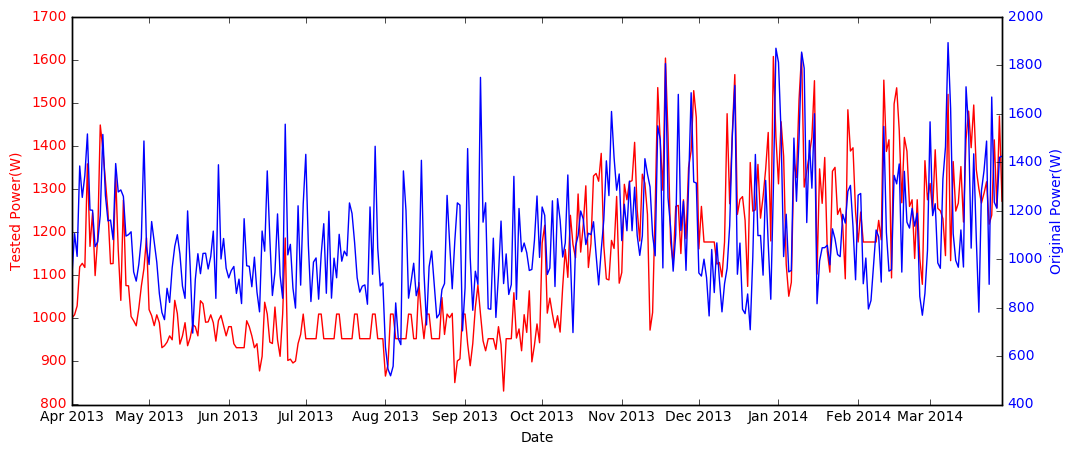

In [21]:
alldataSecondYear = alldata.iloc[np.where(alldata.index.date==dt.date(2013, 4, 1))[0][0]:np.where(alldata.index.date==dt.date(2014, 3, 30))[0][0]]

testX = alldataSecondYear[['temperature','press','visibility','weather','Hour','Weekday']]
testY = alldataSecondYear['Power']
print(mld.score(testX,testY))

testPredictY = pd.DataFrame(mld.predict(testX),index=testX.index,columns=['Power'])
testPredictY = testPredictY.groupby(pd.TimeGrouper(freq='1D')).mean()
testY = testY.groupby(pd.TimeGrouper(freq='1D')).mean()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(testPredictY.index, testPredictY,'r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tested Power(W)', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    
ax2 = ax1.twinx()
ax2.plot(testY.index, testY,'b')
ax2.set_ylabel('Original Power(W)', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')


## PREDICT

We let every temperature increase by 3 to be the new response and the feature dataframe remain the same.

2012-04-30    8.370544e+05
2012-05-31    7.202599e+05
2012-06-30    6.542359e+05
2012-07-31    6.582154e+05
2012-08-31    7.272834e+05
2012-09-30    6.598154e+05
2012-10-31    8.600902e+05
2012-11-30    1.000567e+06
2012-12-31    9.456145e+05
2013-01-31    9.515588e+05
2013-02-28    9.336242e+05
2013-03-31    9.656524e+05
Freq: M, Name: Power, dtype: float64
9913971.883333337
2012-04-30    7.356411e+05
2012-05-31    7.114204e+05
2012-06-30    6.841120e+05
2012-07-31    7.214233e+05
2012-08-31    7.368437e+05
2012-09-30    6.842378e+05
2012-10-31    7.446820e+05
2012-11-30    8.055501e+05
2012-12-31    1.002646e+06
2013-01-31    9.730059e+05
2013-02-28    8.255236e+05
2013-03-31    8.277215e+05
Freq: M, Name: Power, dtype: float64
9452807.17362797
Ratio: 
2012-04-30    0.878845
2012-05-31    0.987727
2012-06-30    1.045666
2012-07-31    1.096029
2012-08-31    1.013145
2012-09-30    1.037014
2012-10-31    0.865818
2012-11-30    0.805093
2012-12-31    1.060311
2013-01-31    1.022539
2013-

C:\Users\jingx\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


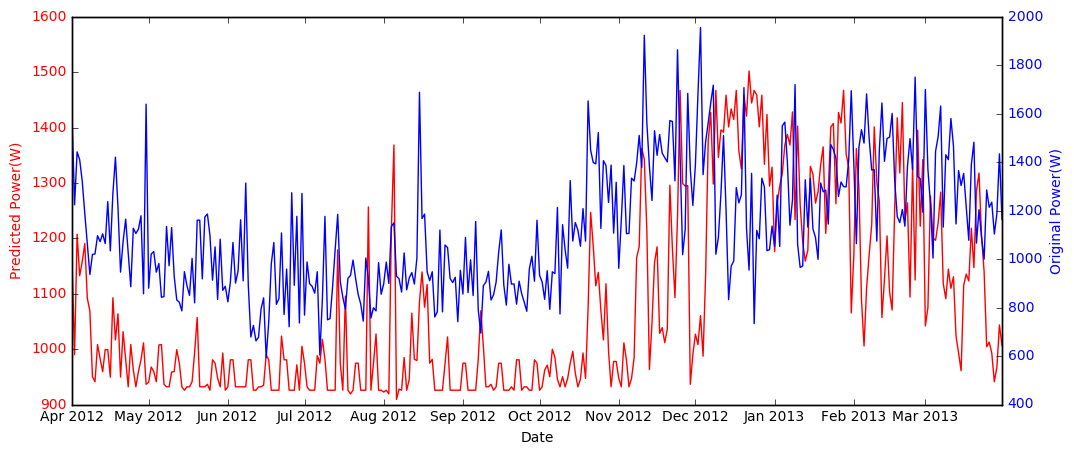

In [22]:
sumConsumption = Y.groupby(pd.TimeGrouper(freq='1M')).sum()
print(sumConsumption)
print(np.sum(sumConsumption))

predictX = X
predictX['temperature']=X['temperature']+3
predictY = pd.DataFrame(mld.predict(predictX),index=predictX.index,columns=['Power'])
preSumCon = predictY.groupby(pd.TimeGrouper(freq='1M')).sum()
print(preSumCon['Power'])
print(np.sum(preSumCon['Power']))
print('Ratio: ')
print(preSumCon['Power']/sumConsumption)
print(np.sum(preSumCon['Power'])/np.sum(sumConsumption))

predictY = predictY.groupby(pd.TimeGrouper(freq='1D')).mean()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(predictY.index, predictY,'r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Power(W)', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    
ax2 = ax1.twinx()
ax2.plot(loadCurves.index, np.mean(Cx,axis=1),'b')
ax2.set_ylabel('Original Power(W)', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')


# Removing Heater Consumption
Modify the original data with removing heater consumption. 

Stem plot of consumpton of data without heater in the first year

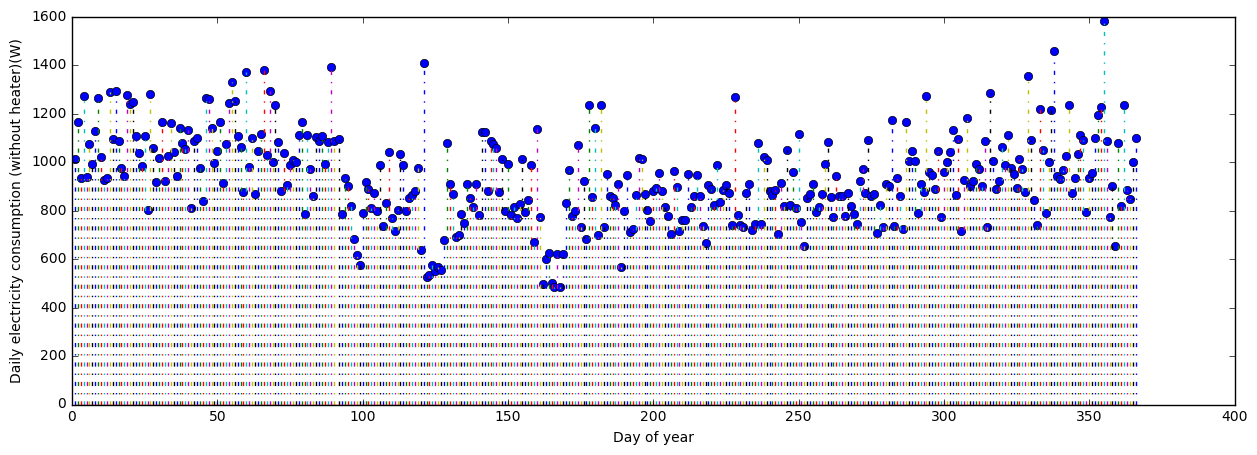

In [23]:
fig = plt.figure(figsize=(15,5))
alldataDaily = alldataOneYear['No heater'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(alldataDaily.index, alldataDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Daily electricity consumption (without heater)(W)')
plt.show()

Heat map of the consumption without heater

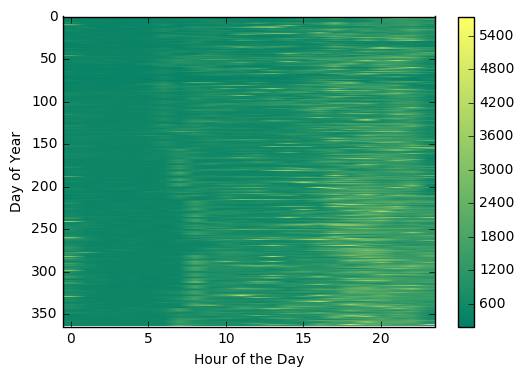

In [24]:
tmp = alldataOneYear[['No heater','Hour','Day']].groupby(['Day','Hour'])['No heater'].mean()
lCNoHeater = tmp.unstack(level=1)

normlCNoHeater = (lCNoHeater-lCNoHeater.min().min())/(lCNoHeater.max().max()-lCNoHeater.min().min())
fig = plt.figure(1)
plt.imshow(lCNoHeater, aspect='auto',cmap='summer')
plt.ylabel('Day of Year')
plt.xlabel('Hour of the Day')
plt.colorbar()
plt.show()


Window average of the consumption without heater

(365, 24)


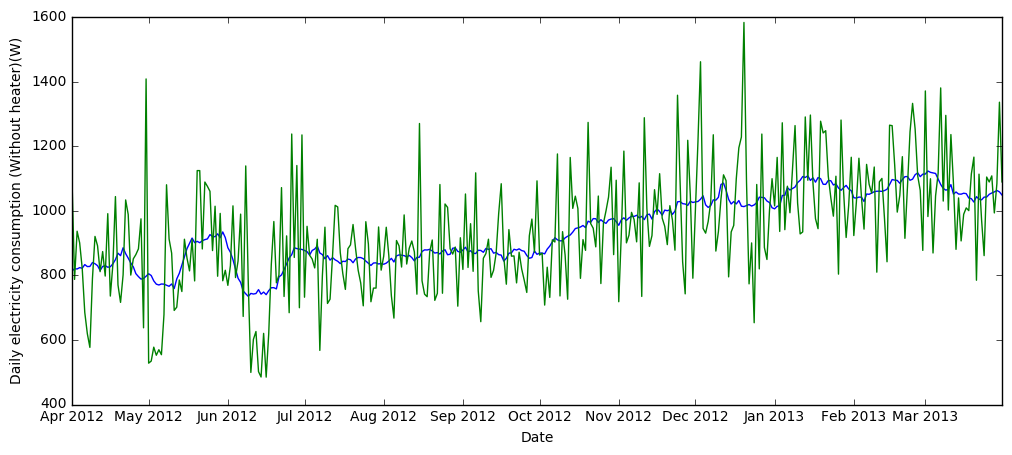

In [25]:
lCNoHeater = lCNoHeater.replace(np.inf,np.nan).fillna(0)

Cx = lCNoHeater.as_matrix().astype(np.float32)
print(Cx.shape)

lp = 10
seasonal = []
for i in range(int(len(Cx))):
    seasonal.append(np.mean(Cx[np.max([i-lp,0]):i+lp,:]))
    
fig = plt.figure(1,figsize=(12,5))
plt.plot(lCNoHeater.index, seasonal, label='seasonal effect')
plt.plot(lCNoHeater.index, np.mean(Cx,axis=1), label='daily average')
plt.xlabel('Date')
plt.ylabel('Daily electricity consumption (Without heater)(W)')

clusters = KMeans(n_clusters=2).fit(normX)

2-means Cluster of consumption without heater

232
133


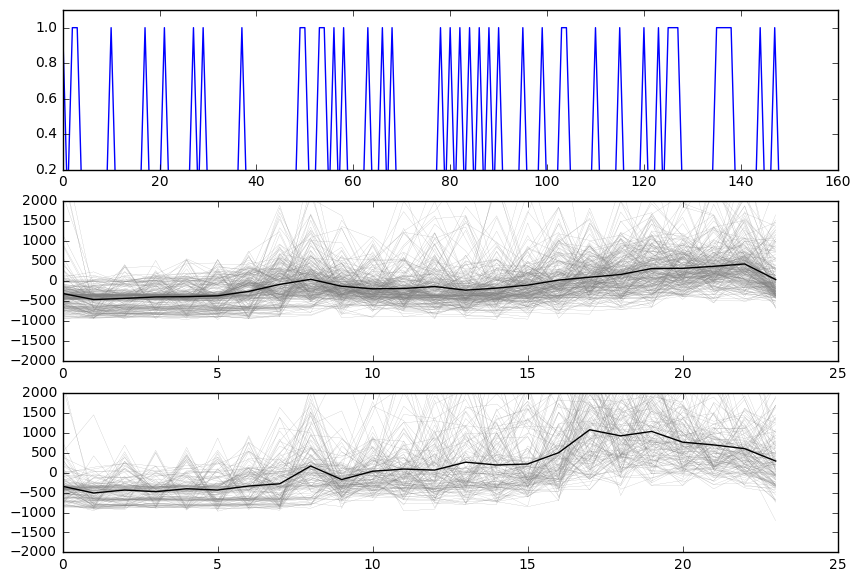

In [26]:
num_clust = 2

fig = plt.figure(1,figsize=(10,7))
cluster_assignments = clusters.predict(normX)
plt.subplot(num_clust+1,1,1)
plt.plot(cluster_assignments[:150])
plt.ylim([0.2,1.1])
for cluster_id in range(len(clusters.cluster_centers_)):
    plt.subplot(num_clust+1,1,cluster_id+2)
    cluster_members = normX[cluster_assignments==cluster_id,:]
    print(len(cluster_members))
    for i in range(len(cluster_members)):
        plt.plot(cluster_members[i,:], color='grey', lw='0.1')
    plt.plot(clusters.cluster_centers_[cluster_id,:], color='k', lw='1')
    plt.ylim([-2000,2000])

Stem plot of heater consumption in the first year

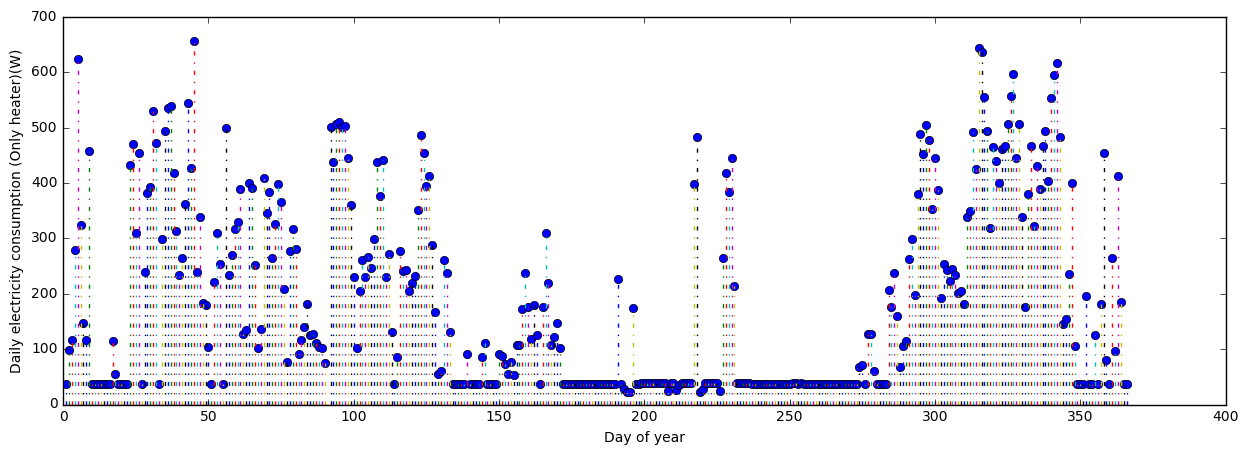

In [27]:
fig = plt.figure(figsize=(15,5))
heaterDaily = alldataOneYear['Heater'].groupby(alldataOneYear.index.dayofyear).mean()
plt.stem(heaterDaily.index, heaterDaily, '-.')
plt.xlabel('Day of year')
plt.ylabel('Daily electricity consumption (Only heater)(W)')
plt.show()

Plot heater consumption and temperature in the first year in one graph.

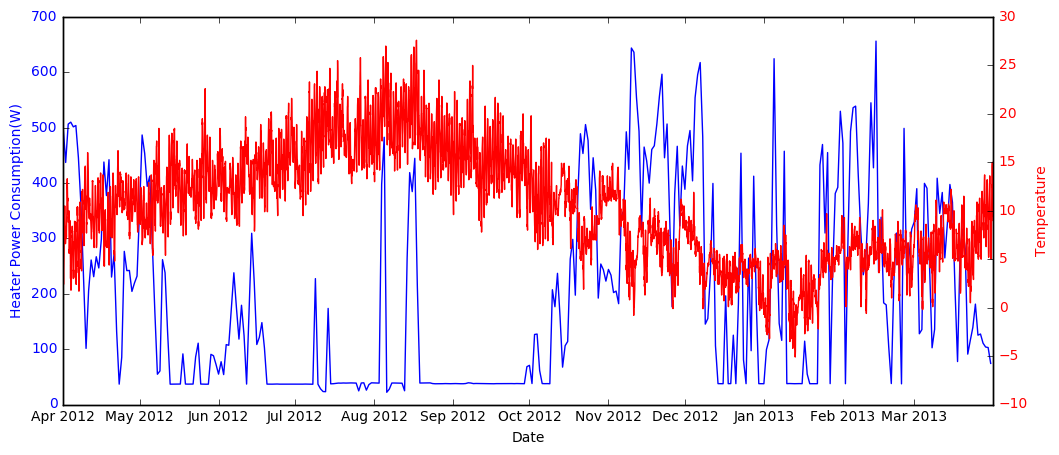

In [28]:
lCHeater = alldataOneYear[['Heater','Hour','Day']].groupby('Day')['Heater'].mean()

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(lCHeater.index, lCHeater,'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heater Power Consumption(W)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(alldataOneYear.index,alldataOneYear['temperature'],'r')
ax2.set_ylabel('Temperature', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()


The max value every month

In [29]:
alldataDay = alldata.resample('1d').mean()
alldataDay['month'] = np.array([x.month for x in alldataDay.index])
alldataDay['weekday'] = np.array([x.weekday() + 1 for x in alldataDay.index])
alldataDay[alldataDay.groupby(['month'])['Power'].transform(max) == alldataDay['Power']]

,temperature,visibility,press,Power,Heater,No heater,Hour,Weekday,Month,month,weekday
2012-04-30,10.237500,22.737500,100.464167,1640.084028,231.920139,1408.163889,11.500000,0.0,4.0,4,1
2012-08-15,21.345833,41.591667,101.377083,1689.090278,418.888889,1270.201389,11.500000,2.0,8.0,8,3
2012-10-20,7.600000,27.137500,100.897500,1653.451389,379.888889,1273.562500,11.500000,5.0,10.0,10,6
2012-11-11,3.062500,22.412500,102.167500,1924.441667,636.347222,1288.094444,11.500000,6.0,11.0,11,7
2012-12-03,7.504167,22.366667,100.967917,1956.360417,494.947917,1461.412500,11.500000,0.0,12.0,12,1
2013-02-25,6.558333,21.645833,101.377083,1751.697222,498.809028,1252.888194,11.500000,0.0,2.0,2,1
2013-05-28,12.421739,16.721739,100.930870,1389.872464,109.358696,1280.513768,11.956522,1.0,5.0,5,2
2013-06-23,16.478571,25.728571,100.586429,1557.339286,37.636905,1519.702381,14.214286,6.0,6.0,6,7
2013-07-28,18.125000,46.287500,101.435000,1466.204167,37.697917,1428.506250,11.500000,6.0,7.0,7,7
2013-09-07,18.200000,22.312500,101.783750,1750.633333,37.541667,1713.091667,11.500000,5.0,9.0,9,6
